# General Public License Disclaimer

    Script to run ribosome analysis
    Copyright (C) 2019  Fuad Mohammad, fuadm424@gmail.com


    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
    



# Density analysis script

This notebook will use density files made from the FASTQ processing script and analyze features relevant to translation. This can also be applied to RNA-seq to investigate RNA coverage over the CDS:

   - 

   - Average gene plot condenses ribosome footprints aligned to the start and stop codons of every gene. 
       - Initiation and termination 
       - periodicity
       - occupancy on CDS and UTR
   - Frame analysis condenses reads into the three reading frames, informing on the occupancy at each frame. ribosome footprints should show strong 3nt periodicity. 
       - Frame analyzed using all density sizes, size separated densities, or gene separated 
   - Assymetry analysis informs on the degree of dropoff/runoff in the data. 
   - Pause score analysis provides relative occupancy information on different codons/amino acids. 

# General Settings:

Directory Data:

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime


import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot


# File names can be manually added to list, or read as .csv with header == Library
# Library names must be the same as the fastq file name

path_pc     = '/Volumes/HDD/Mohammad_2018/'  # location of folder for ribosome profiling
path_script = '/Users/fuad/Dropbox/'

all_files  = []                              # sample name, same as FASTQ filename
file_csv   = path_pc  + 'Library_names.csv'  # alternatively, provide .csv with filenames

library_id = pd.read_csv(file_csv)

for fname in library_id.Library:
    all_files.append(fname)
print all_files

inputs = {}
inputs['files'] = []
inputs['multiprocess'] = 'yes'
inputs['threads']      = 8   # CPU information for multithreading applications
inputs['cores']        = 4

paths_in = {}
paths_in['path_gff']        = path_pc + 'annotations/Coli/Coli.gff'
paths_in['path_gff_dict']   = path_pc + 'annotations/Coli/Coli_dict'       # this will be made from the GFF file
paths_in['path_badgenes']   = path_pc + 'annotations/Coli/bad_genes.csv'   # list of genes to exclude
paths_in['path_annotation'] = path_pc + 'annotations/Coli/annotation.csv'  # adds gene description to GFF_dict 

# Outputs from analysis will be placed in the foillowing directories:
paths_out = {}
paths_out['path_density']      = path_pc  + 'libraries/density/density/'  # Created from Ribo_Density
paths_out['path_log']          = path_pc  + 'libraries/density/logs/'
paths_out['path_analysis_log'] = path_pc  + 'libraries/analysis/logs/'
paths_out['path_analysis']     = path_pc  + 'libraries/analysis/individual/'
paths_out['path_figures']      = path_pc  + 'libraries/figures/'

    
# Check inputs, create output paths
step = 'analysis'                                # density or analysis
ribo_util.check_inputs(inputs, paths_in, step)   # will remove file from analysis for not having a density file
ribo_util.createpath(inputs, paths_out)          # create output paths


['CW63']


# Analysis Settings

Set settings values for the various analyses

In [2]:
# General Settings 
settings = {}
settings['minlength'] = 15    # minimum read lenght
settings['maxlength'] = 40    # maximum read length
settings['shift']     = 11    # A-site shift
settings['gff_extra'] = 50    # Number of nt added before start seq and after stop seq in GFF_dict
settings['threshold'] = 1    # in reads per codon
settings['alignment'] = '3'   # '3' or '5'

# Avggenes Settings
settings['length_out_ORF'] = 50
settings['length_in_ORF']  = 100        # genes shorter than this are excluded
settings['density_type']   = 'reads'    # 'reads' or 'rpm' 
settings['equal_weight']   = 'yes'      # 'yes' or 'no', if yes, change density_type to reads -- faster
settings['next_gene']      = 25         # genes closer than this are removed from start and stop 

# Pausescore settings
settings['A_site shift']    = -11
settings['plot_upstream']   = 40
settings['plot_downstream'] = 50
settings['start_trim']      = 50
settings['stop_trim']       = 20
settings['frameshift']      = 0

# Genelist settings


# Pausescore waves settings
settings['plot_upstream_wave']   = 0
settings['plot_downstream_wave'] = 106
settings['next_codon']           = 'yes'

# Motif analysis
settings['motif_length'] = 9


# Create Annotation dictionary from GFF

Pipeline uses a simplified dictionary of the GFF for speed. This function will strip the GFF to the gene name, start and stop position, and sequence of the gene

This needs to be run only once, so you can comment it off once it does run


In [3]:
gff_settings = {}
gff_settings['path_out']         = 0             # set to 0 to output in annotations folder
gff_settings['feat_of_interest'] = 'all'         # all, CDS, tRNA, rRNA: recommend using all
gff_settings['name_qual']        = 'Name'        # GFF gene qualifier
gff_settings['name_qual_alt']    = 'ID'          # Secondary GFF gene qualifier if no name is present
gff_settings['remove_genes']     = 'yes'         # remove hard to align genes listed in bad_genes.csv
gff_settings['gff_extra']         = 50           # additional sequence upstream and downstream of gene (set to 50)

#GFF_conversion = ribo_util.GFF_to_dict(paths_in, gff_settings)


In [5]:
lib_count = len(all_files)
lib_index = 0 
lib_runs  = 8  # limits number of samples processed, scale with RAM imitations

for loops in range(0, lib_count / lib_runs + 2):

    if lib_index < lib_count:
        print "Started  at " + str(datetime.now())
        if lib_count - lib_index >= lib_runs:
            inputs['files'] = [all_files[i] for i in range(lib_index, lib_index + lib_runs)]

            print inputs['files']
            
            if not 'gff_dict' in globals(): 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            else: 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            
            average_gene = ribo_analysis.avggenes(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            pausescore_analysis = ribo_analysis.pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            genelists = ribo_analysis.genelist(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            asymmetry_analysis = ribo_analysis.asymmetry(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            frame_analysis     = ribo_analysis.frame(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            wave_analysis = ribo_analysis.pausescore_waves(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            
        else:
            inputs['files'] = [all_files[i] for i in range(lib_index, lib_count)]
            
            print inputs['files']    
            if not 'gff_dict' in globals(): 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
            else: 
                gff_dict, plus_dict, minus_dict = ribo_util.loadlargePickles(inputs, settings, paths_in, paths_out)
                
            average_gene = ribo_analysis.avggenes(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            pausescore_analysis = ribo_analysis.pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            genelists = ribo_analysis.genelist(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            asymmetry_analysis = ribo_analysis.asymmetry(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            frame_analysis     = ribo_analysis.frame(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            wave_analysis = ribo_analysis.pausescore_waves(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)
            motif_analysis = ribo_analysis.motif_pausescore(inputs, paths_out, settings, gff_dict, plus_dict, minus_dict)

    else:
        continue
    lib_index += lib_runs  
print "Finished  at " + str(datetime.now())

Started  at 2019-05-29 14:27:55.383581
['CW63']
Started avggenes at 2019-05-29 14:29:02.742506
	For CW63: 364 out of 4432 genes in average.
	    - genes failing distance cutoff = 1624
	    - genes failing length cutoff   = 31
	    - genes failing RPM cutoff      = 2144
	    - non-coding genes              = 269
Finished avggenes at 2019-05-29 14:29:16.629502
Started pause score analysis at 2019-05-29 14:29:16.630670
Finished pause score analysis at 2019-05-29 14:30:25.565644
Started genelist analysis at 2019-05-29 14:30:25.567093
Finished genelist analysis at 2019-05-29 14:31:35.024781
Started asymmetry analysis at 2019-05-29 14:31:35.025366


ribo_analysis.py:1345: RuntimeWarning:

divide by zero encountered in log2



Finished asymmetry analysis at 2019-05-29 14:31:36.697396
Started frame analysis at 2019-05-29 14:31:36.697523
Finished frame analysis at 2019-05-29 14:31:47.839379
Started pause score analysis at 2019-05-29 14:31:47.840865
545
1386
68
2433
Finished pause score analysis at 2019-05-29 14:39:08.479545
Started pause score analysis at 2019-05-29 14:39:08.480812
437
1412
72
2511
Finished pause score analysis at 2019-05-29 15:05:35.940088
Finished  at 2019-05-29 15:05:35.982723


# --------------------------------------------------------------------------


# Gene Average Analysis:

Calculate average ribosome occupancy aligned at start or stop codons, as well the symmetry of ribosome distribution on genes and the periodicity associated with the density

Settings for asymmetry analysis:

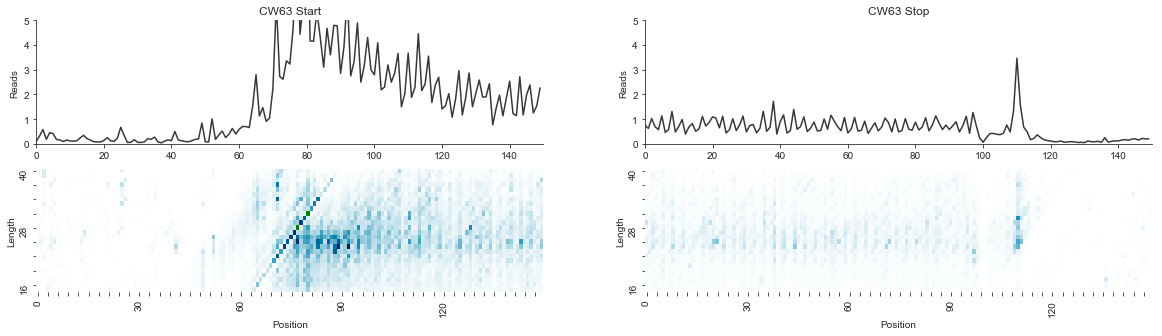

In [6]:
inputs['files'] = all_files

settings_plot = {}
settings_plot['HM_max'] = 2
settings_plot['shift']  = 15
settings_plot['ymax']   = 5

average_plot = ribo_plot.plot_avggene(inputs, paths_in, paths_out, settings, settings_plot)

# Frame Analysis

Calculate reading frame of all footprints, as well as for each readlength and each gene:

   - RPKM threshold used above still applies. To change, redefine below 

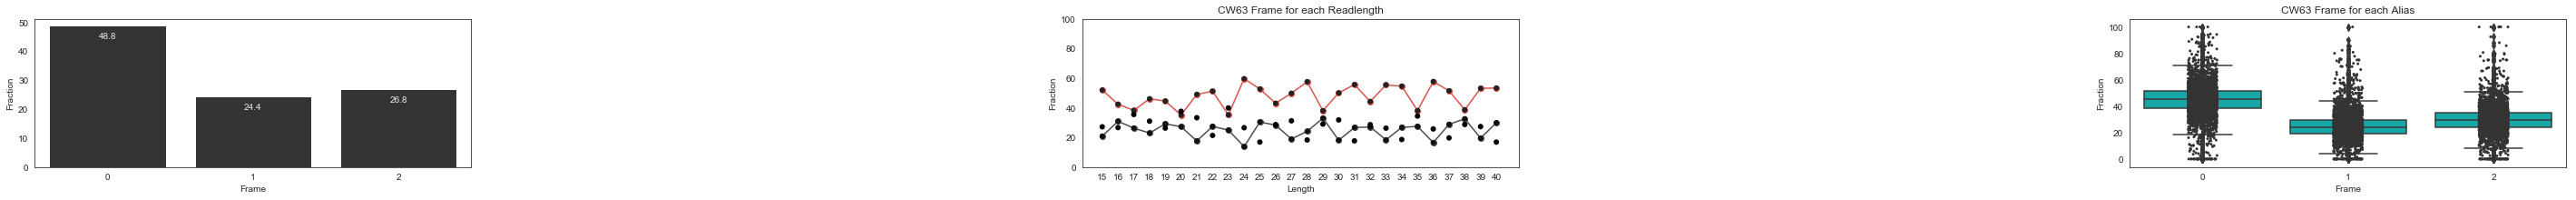

In [7]:
frame_plot = ribo_plot.plot_frame(inputs, paths_in, paths_out, settings, settings_plot)

# Pause Score Analysis

Calculate pause scores for each amino acid, and for each codon. 

   - relative density = (reads at position / average reads of the gene)
   - pause score = avg(relative density over codon or aa) / instances of the codon oraa

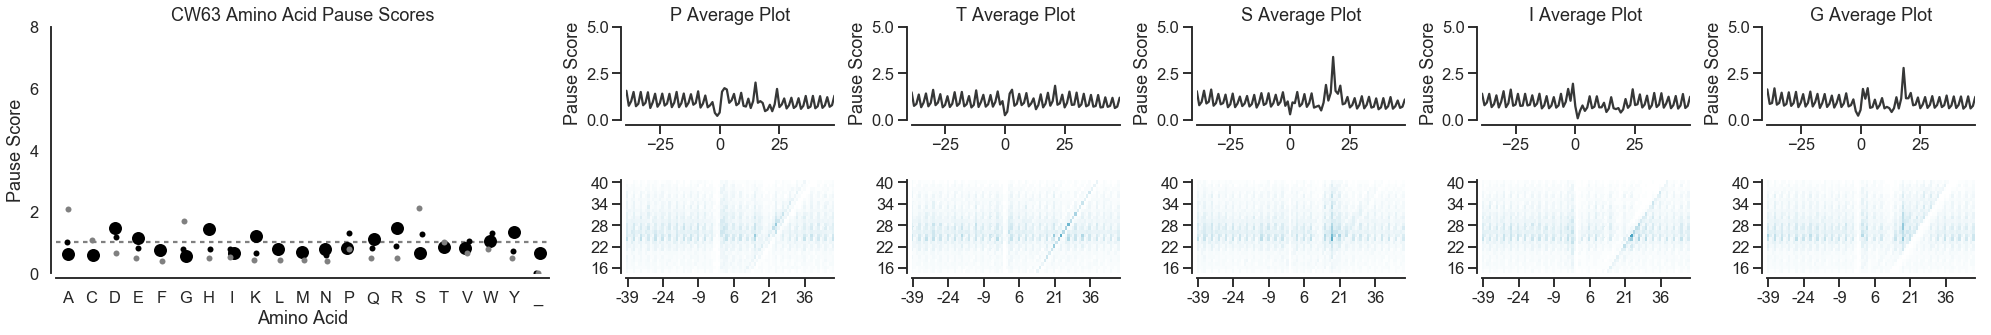

In [8]:
settings_plot['aa_or_codon'] = 'aa' 
settings_plot['amino_acid']  = ['P', 'T', 'S', 'I', 'G']
settings_plot['codon']       = ['ATT', 'ATC', 'CCT', 'CCA', 'CCG', 'ACT']

settings_plot['ymax_dot']  = 8
settings_plot['ymax_line'] = 5
settings_plot['vmax_HM']   = 2

plot_pausescore = ribo_plot.plot_pausescore(inputs, paths_in, paths_out, settings, settings_plot)

# Gene Density

Display density of listed genes

   - RPKM threshold used above still applies. To change, redefine below 

# Compare Pausescores

Analyze pausescores using heatmaps:

In [11]:
paths_in['files']          = file_csv   # I like to be able to choose which samples to compare. 
settings_plot['center_HM'] = 1
settings_plot['vmax_HM']   = 2

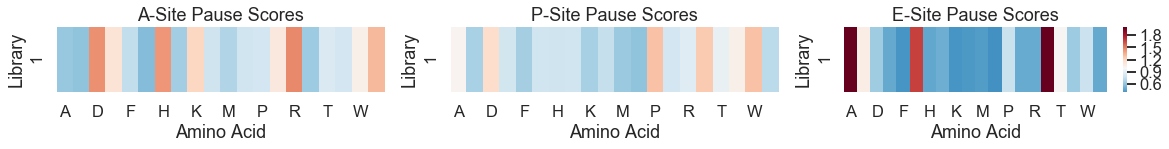

In [16]:
Pause_heatmap = ribo_plot.plot_pausescore_APE_heatmap(inputs, paths_in, paths_out, settings, settings_plot)

# Serine Wave Plots

Plot ribosome occupancy downstream of serine pauses

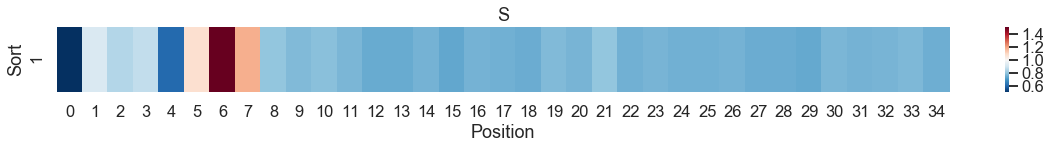

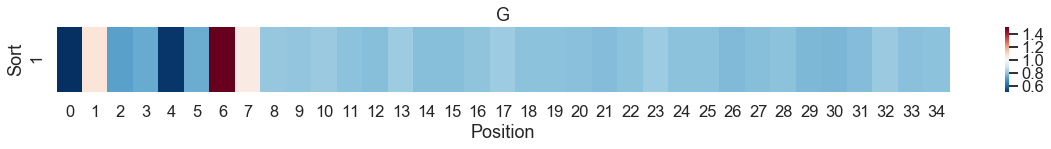

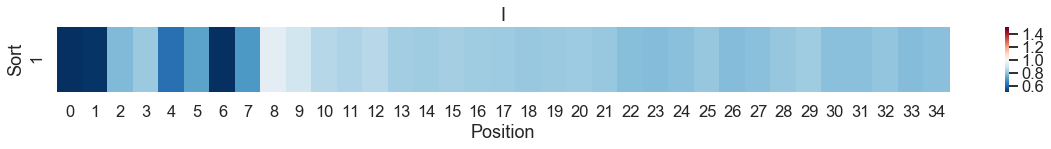

In [19]:
paths_in['files']            = file_csv
settings_plot['amino_acid']  = ['S', 'G', 'I']
settings_plot['center_HM']   = 1
settings_plot['vmax_HM']     = 1.5


Pause_wave = ribo_plot.plot_pausescore_downstream(inputs, paths_in, paths_out, settings, settings_plot)

# Asymmetry Plot

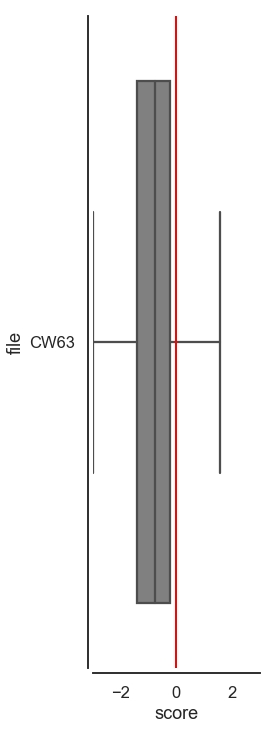

In [29]:
asymmetry = ribo_plot.plot_asymmetry_comp(inputs, paths_in, paths_out, settings)